In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [4]:
def load_and_preprocess_data():
    customers_df = pd.read_csv('Downloads/Customers.csv')
    transactions_df = pd.read_csv('Downloads/Transactions.csv')

    print("Columns in Transactions.csv:", transactions_df.columns)
    print("Columns in Customers.csv:", customers_df.columns)

    trans_agg = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],  
        'TransactionDate': 'count'           
    }).reset_index()

    trans_agg.columns = ['CustomerID', 'total_amount', 'avg_amount', 'transaction_count', 'visit_frequency']

    final_df = customers_df.merge(trans_agg, on='CustomerID', how='left')

    final_df.fillna({
        'total_amount': 0,
        'avg_amount': 0,
        'transaction_count': 0,
        'visit_frequency': 0
    }, inplace=True)

    return final_df

In [5]:
def calculate_db_index(X, labels, centroids):
    n_clusters = len(np.unique(labels))
    cluster_k = [X[labels == k] for k in range(n_clusters)]
    
    s = [np.mean([np.linalg.norm(p - centroids[i]) for p in cluster_k[i]])
         if len(cluster_k[i]) else 0 for i in range(n_clusters)]
    
    db = 0
    for i in range(n_clusters):
        if len(cluster_k[i]) == 0:
            continue
        max_ratio = 0
        for j in range(n_clusters):
            if i != j and len(cluster_k[j]) > 0:
                ratio = (s[i] + s[j]) / np.linalg.norm(centroids[i] - centroids[j])
                max_ratio = max(max_ratio, ratio)
        db += max_ratio
    
    return db / n_clusters if n_clusters > 1 else 0

In [6]:
def perform_clustering(data, n_clusters):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    metrics = {
        'db_index': calculate_db_index(scaled_features, clusters, kmeans.cluster_centers_),
        'silhouette': silhouette_score(scaled_features, clusters),
        'calinski_harabasz': calinski_harabasz_score(scaled_features, clusters)
    }
    return clusters, metrics, scaled_features, kmeans

In [7]:
def visualize_clusters(scaled_features, clusters, metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    plt.subplot(2, 2, 2)
    from sklearn.metrics import silhouette_samples
    silhouette_vals = silhouette_samples(scaled_features, clusters)
    
    for i in range(len(np.unique(clusters))):
        ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
        plt.hist(ith_cluster_silhouette_vals, bins=20, alpha=0.5, label=f'Cluster {i}')
    
    plt.axvline(x=metrics['silhouette'], color='red', linestyle='--', label='Average')
    plt.title('Silhouette Score Distribution')
    plt.xlabel('Silhouette Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
def main():
    final_df = load_and_preprocess_data()
    features = ['total_amount', 'avg_amount', 'transaction_count', 'visit_frequency']
    
    # Extract features for clustering
    X = final_df[features]
    
    # Try different numbers of clusters to find optimal
    n_clusters_range = range(2, 7)
    db_scores = []
    silhouette_scores = []
    ch_scores = []
    
    for n_clusters in n_clusters_range:
        clusters, metrics, scaled_features, kmeans = perform_clustering(X, n_clusters)
        db_scores.append(metrics['db_index'])
        silhouette_scores.append(metrics['silhouette'])
        ch_scores.append(metrics['calinski_harabasz'])
    
    # Find optimal number of clusters (minimum DB index)
    optimal_n_clusters = n_clusters_range[np.argmin(db_scores)]
    
    # Perform final clustering with optimal number of clusters
    final_clusters, final_metrics, final_scaled_features, final_kmeans = perform_clustering(X, optimal_n_clusters)
    
    # Print results
    print("\nClustering Results:")
    print(f"Number of clusters formed: {optimal_n_clusters}")
    print(f"DB Index value: {final_metrics['db_index']:.4f}")
    print(f"Silhouette Score: {final_metrics['silhouette']:.4f}")
    print(f"Calinski-Harabasz Score: {final_metrics['calinski_harabasz']:.4f}")
    
    # Visualize the clusters
    visualize_clusters(final_scaled_features, final_clusters, final_metrics)
    
    # Add cluster labels to the original dataframe
    final_df['Cluster'] = final_clusters
    
    # Calculate cluster statistics
    cluster_stats = final_df.groupby('Cluster')[features].mean()
    print("\nCluster Statistics:")
    print(cluster_stats)

Columns in Transactions.csv: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')
Columns in Customers.csv: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')

Clustering Results:
Number of clusters formed: 5
DB Index value: 0.8360
Silhouette Score: 0.3577
Calinski-Harabasz Score: 146.8806


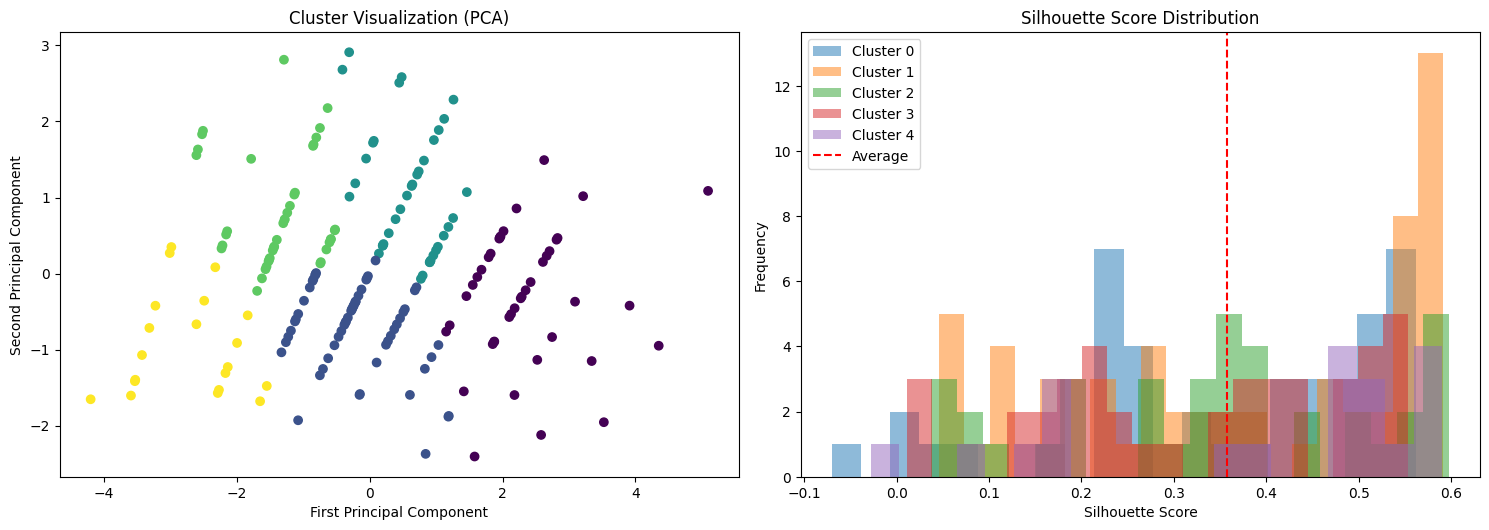


Cluster Statistics:
         total_amount  avg_amount  transaction_count  visit_frequency
Cluster                                                              
0         5862.763095  730.134295           8.119048         8.119048
1         2777.771525  533.065105           5.271186         5.271186
2         4614.432368  938.811219           5.026316         5.026316
3         2230.820000  798.457134           2.853659         2.853659
4          652.947000  315.020292           2.000000         2.000000


In [9]:
if __name__ == "__main__":
    main()